## HW1 - generate block simulation data and solve for the parameters

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import MatrixMethods as mm
from SingleImage import SingleImage
from ImageBlock import ImageBlock
from BlockSimulation import *
from scipy import linalg as la
from functools import partial


# Set print options to suppress scientific notation
np.set_printoptions(suppress=True)

## Part 1 - Simulate block of images

In [300]:
# define random seed
np.random.seed(0)

a = SimulateBlock(50, (36, 24), overlap=0.6 , num_images=10, tie_pattern='3 mid frame', control_pattern='random block',num_control_points=10, rotaions_sigma=10, altitude=1000)

block = a.simulate_block()

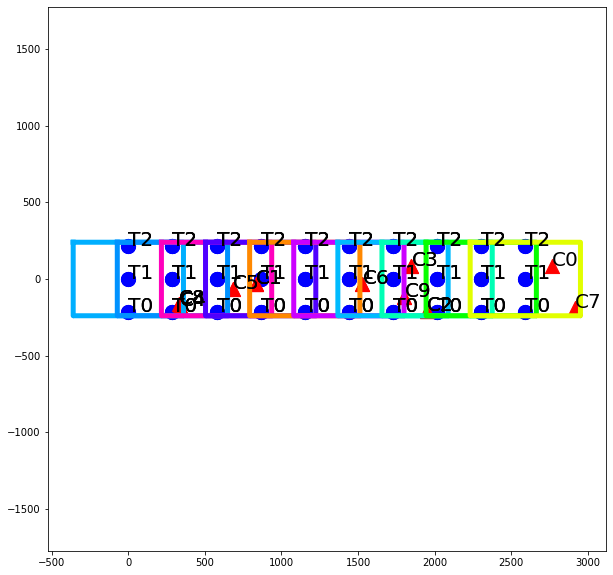

In [301]:
ax = block.draw_block(anotate=True)
ax.axis('equal')
plt.show()

In [302]:
block.describe_block()

Images EOP:
   Image      X0   Y0      Z0     omega       phi     kappa
0    0.0     0.0  0.0  1000.0  0.000086  0.000019  0.000047
1    1.0   288.0  0.0  1000.0  0.000109  0.000091 -0.000047
2    2.0   576.0  0.0  1000.0  0.000046 -0.000007 -0.000005
3    3.0   864.0  0.0  1000.0  0.000020  0.000007  0.000071
4    4.0  1152.0  0.0  1000.0  0.000037  0.000006  0.000022
5    5.0  1440.0  0.0  1000.0  0.000016  0.000072 -0.000010
6    6.0  1728.0  0.0  1000.0  0.000015 -0.000041 -0.000124
7    7.0  2016.0  0.0  1000.0  0.000032  0.000042 -0.000036
8    8.0  2304.0  0.0  1000.0  0.000110 -0.000071  0.000002
9    9.0  2592.0  0.0  1000.0 -0.000009  0.000074  0.000071

Tie points:
    x     y name image_id            X           Y             Z  num_images
0   0 -10.8   T0        0    -0.009151 -215.910488  0.000000e+00           2
1   0   0.0   T1        0    -0.019400    0.085524  0.000000e+00           2
2   0  10.8   T2        0    -0.029650  216.089516  0.000000e+00           2
3   0 -

## Part 2 - Bundle Adjustment

In [303]:
img = block.images[0]
Compute3DRotationMatrix(*img.exteriorOrientationParameters[3:])

array([[ 1.        , -0.00004745,  0.0000194 ],
       [ 0.00004745,  1.        , -0.00008552],
       [-0.0000194 ,  0.00008552,  1.        ]], dtype=float32)

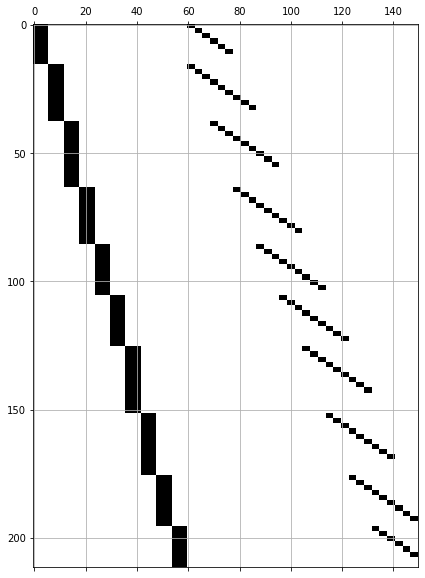

In [304]:
# drawing A matrix
A = block.ComputeDesignMatrix()
plt.figure(figsize=(10,10))
plt.spy(A)
plt.grid()
plt.show()

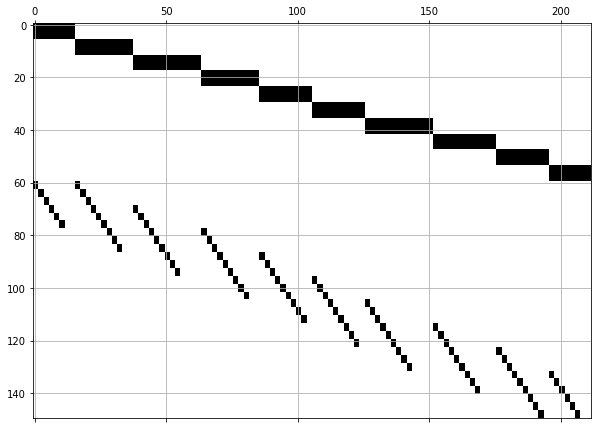

In [305]:
# drawing A matrix
A = block.ComputeDesignMatrix()
plt.figure(figsize=(10,10))
plt.spy(A.T)
plt.grid()
plt.show()

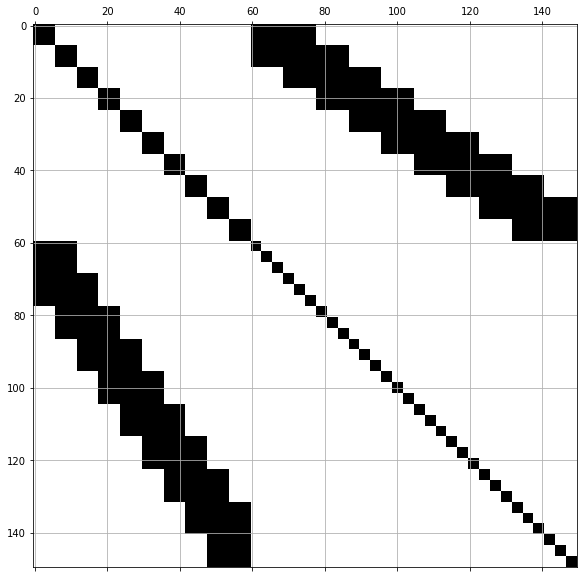

In [306]:
# drawing A matrix
N = np.dot(A.T, A)
plt.figure(figsize=(10,10))
plt.spy(N)
plt.grid()
plt.show()

In [307]:
At = A.T

In [308]:
# build Normal matrix blocks
def ComputeN11Image(Ai, image):
    """ Compute N11 matrix for a single image
    input:
        Ai: design matrix for a single image (2*number of ground points, 6)
        image: image object
    output:
        N11i: N11 matrix for a single image (6,6)
    """
    print(Ai.shape)
    # N11i = np.zeros((6, 6))
    N11i = sum(map(lambda i: Ai[2*i:2*i+2, :].T @ Ai[2*i:2*i+2, :], range(image.ground_coords.shape[0])))
    # for i in range(image.ground_coords.shape[0]):
    #     Aij = Ai[2*i:2*i+2, :]
    #     N11i += Aij.T @ Aij
    
    
    # A_reshaped = np.reshape(Ai, (-1, 6, 6))
    # Aij = np.transpose(A_reshaped, axes=(0, 2, 1))
    # N11i = np.sum(Aij @ A_reshaped, axis=0)
    return N11i

def ComputeN11Block(A, block):
    
    # creating lists of rows and cloumns indices
    A_indices_rows = np.hstack((0,np.cumsum([img.ground_coords.shape[0] * 2 for img in block.images])))    
    A_indices_cols = np.arange(0,len(block.images)*6+1,6)
    # slicing A matrix for computing N11i blocks
    A_slices = list(map(lambda r1,r2,c1,c2: A[r1:r2,c1:c2],A_indices_rows[:-1],A_indices_rows[1:],A_indices_cols[:-1],A_indices_cols[1:]))
    # computing N11i blocks
    N11i_blocks = list(map(lambda x: ComputeN11Image(*x), zip(A_slices, block.images)))
    
    # N11i_blocks = []
    # A_index_start=0
    # A_index_end=0
    # for i,img in enumerate(block.images):
    #     A_index_end += img.ground_coords.shape[0]*2
    #     print(f'A indices: {A_index_start}, {A_index_end}')
    #     N11i_blocks.append(ComputeN11Image(A[A_index_start:A_index_end,i*6:i*6+6], img))
    #     A_index_start = A_index_end
    N11 = la.block_diag(*N11i_blocks)     
    return N11
    
def ComputeN22Block(A, block):
    N22k_blocks = []
    # compute N22 for each tie point - variable index
    N22k_blocks = block.block_points.groupby('tie_block_id').apply(ComputeN22k, A=A)
        
    return la.block_diag(*N22k_blocks)

def ComputeN22k(group, A):
    # Access the original indices and image_ids of the group - observation indices
    original_indices = group.index.values  #   
    image_ids = group['image_id'].values    
    
    
    N22k = sum(map(lambda i,j: -A[j*2:j*2+2, 6*image_ids[i]:6*image_ids[i]+3].T @ -A[j*2:j*2+2, 6*image_ids[i]:6*image_ids[i]+3], np.arange(len(original_indices)),original_indices))
    
    # N22k = np.zeros((3,3))
    # for i,j in enumerate(original_indices):
    #     Bjk = -A[j*2:j*2+2, 6*image_ids[i]:6*image_ids[i]+3]
    #     N22k += Bjk.T @ Bjk
        
    return N22k 

def ComputeN12Block(A, block):
    # N12_blocks=[]
            
    # A_index_start=0
    # A_index_end=0
    # for i,img in enumerate(block.images):
    #     A_index_end += img.ground_coords.shape[0]*2 
    #     N12i = ComputeN12i(block, A[A_index_start:A_index_end,i*6:i*6+6], img)
    #     N12_blocks.append(N12i)
    #     A_index_start = A_index_end
        
        
    # creating lists of rows and cloumns indices
    A_indices_rows = np.hstack((0,np.cumsum([img.ground_coords.shape[0] * 2 for img in block.images])))    
    A_indices_cols = np.arange(0,len(block.images)*6+1,6)
    # slicing A matrix for computing N11i blocks
    A_slices = list(map(lambda r1,r2,c1,c2: A[r1:r2,c1:c2],A_indices_rows[:-1],A_indices_rows[1:],A_indices_cols[:-1],A_indices_cols[1:]))
    # computing N12 blocks
    temp_ComputeN12i = partial(ComputeN12i, block)
    N12_blocks = list(map(lambda x: temp_ComputeN12i(*x), zip(A_slices, block.images)))
    
        
    return np.vstack(N12_blocks)

def ComputeN12i(block, Ai, img):
   
    observation_indices_in_img = img.tie_points['tie_block_id'].values
    print(observation_indices_in_img)    
    # N12i = np.zeros((6,block.tie_points.shape[0]*3))

    # for i,j in enumerate(observation_indices_in_img):
    #     print(i,j)

    #     Aij = Ai[i*2:i*2+2, :6]
    #     Bjk = -Ai[i*2:i*2+2, :3]
    #     N12i[:6,j*3:j*3+3] = Aij.T @ Bjk
        
        
        
    def populateN12i(i):
        if i in observation_indices_in_img:            
            i = np.where(observation_indices_in_img == i)[0][0] 
            Aij = Ai[i*2:i*2+2, :6]
            Bjk = -Ai[i*2:i*2+2, :3]
            N12i = Aij.T @ Bjk
        else:            
            N12i = np.zeros((6,3))
                    
        return N12i
        
    # # temp_populateN12i = partial(populateN12i,N12i)
    N12i = np.hstack(list(map(populateN12i, np.arange(block.tie_points.shape[0]))))
        
    return N12i

In [309]:
temp = block.tie_points

In [310]:
A_indices_rows = np.hstack((0,np.cumsum([img.ground_coords.shape[0] * 2 for img in block.images])))
print(A_indices_rows)
A_indices_col = np.arange(0,len(block.images)*6+1,6)
print(A_indices_col)
A_slices = list(map(lambda r1,r2,c1,c2: A[r1:r2,c1:c2],A_indices_rows[:-1],A_indices_rows[1:],A_indices_col[:-1],A_indices_col[1:]))
for slice in A_slices:
    print(slice.shape)
    
A.shape

[  0  16  38  64  86 106 126 152 176 196 212]
[ 0  6 12 18 24 30 36 42 48 54 60]
(16, 6)
(22, 6)
(26, 6)
(22, 6)
(20, 6)
(20, 6)
(26, 6)
(24, 6)
(20, 6)
(16, 6)


(212, 150)

In [311]:
N11_o = N[:6*len(block.images),:6*len(block.images)]
N12_o = N[:6*len(block.images),6*len(block.images):]
N21_o = N[6*len(block.images):,:6*len(block.images)]
N22_o = N[6*len(block.images):,6*len(block.images):]

N11 = ComputeN11Block(A, block)
N12 = ComputeN12Block(A, block)
N22 = ComputeN22Block(A, block)

(16, 6)
(22, 6)
(26, 6)
(22, 6)
(20, 6)
(20, 6)
(26, 6)
(24, 6)
(20, 6)
(16, 6)
[0 1 2 3 4 5]
[0 1 2 3 4 5 6 7 8]
[ 3  4  5  6  7  8  9 10 11]
[ 6  7  8  9 10 11 12 13 14]
[ 9 10 11 12 13 14 15 16 17]
[12 13 14 15 16 17 18 19 20]
[15 16 17 18 19 20 21 22 23]
[18 19 20 21 22 23 24 25 26]
[21 22 23 24 25 26 27 28 29]
[24 25 26 27 28 29]


In [312]:
# compare N11_o to N11 
print(sum(sum((N11_o-N11)**2)))
print(sum(sum((N12_o-N12)**2)))
print(sum(sum((N22_o-N22)**2)))

2.0597432841982416e-22
0.0
2.806145427610416e-35


In [281]:
temp = N12_o-N12

In [ ]:
block.tie_points

,x,y,name,image_id,X,Y,Z,num_images
0,0,-10.8,T0,0,-0.009151,-215.910488,0.000000e+00,2
1,0,0.0,T1,0,-0.019400,0.085524,0.000000e+00,2
2,0,10.8,T2,0,-0.029650,216.089516,0.000000e+00,2
3,0,-10.8,T0,1,287.899227,-215.886293,0.000000e+00,3
4,0,0.0,T1,1,287.909458,0.108642,0.000000e+00,3
5,0,10.8,T2,1,287.919690,216.113713,0.000000e+00,3
6,0,-10.8,T0,2,576.006257,-215.951790,0.000000e+00,3
7,0,0.0,T1,2,576.007338,0.046062,0.000000e+00,3
8,0,10.8,T2,2,576.008419,216.048211,-1.136868e-13,3
9,0,-10.8,T0,3,864.008246,-215.979165,-1.136868e-13,2


[0 1 2 3 4 5]


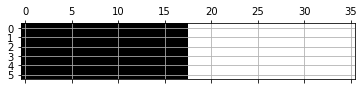

[0 1 2 3 4 5 6 7 8]


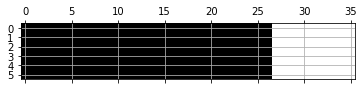

[ 3  4  5  6  7  8  9 10 11]


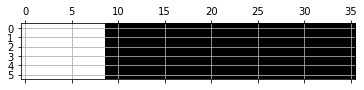

[ 6  7  8  9 10 11]


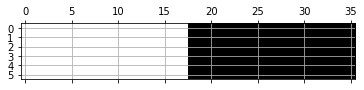

In [ ]:
N12 = ComputeN12Block(A, block)

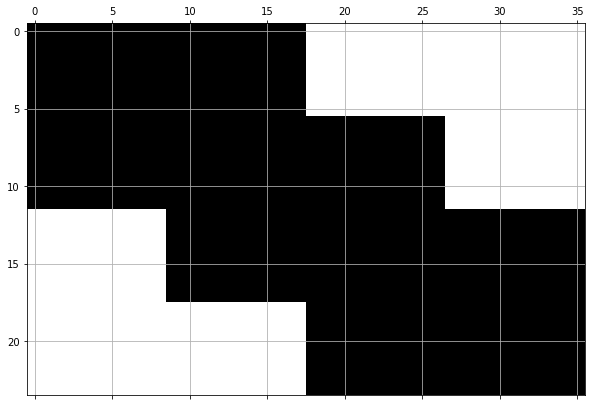

In [ ]:

plt.figure(figsize=(10,10))
plt.spy(N12)
plt.grid()
plt.show()

In [ ]:
N12_o = N[:6*len(block.images),6*len(block.images):]
sum(sum(N12 - N12_o))

0.0

In [ ]:
import numpy as np
from scipy.sparse import coo_matrix

# Assume we have a design matrix with shape (m, n)
# where m is the number of observations and n is the number of parameters

# Convert the design matrix to a sparse matrix representation
sparse_matrix = coo_matrix(A)

# Print the sparse matrix
print(sparse_matrix)


  (0, 0)	-0.050000923281061004
  (0, 1)	-2.372654645577606e-06
  (0, 2)	9.698234719196833e-07
  (0, 3)	-0.0025820497044271662
  (0, 4)	50.0
  (0, 5)	-10.800000020420477
  (0, 24)	0.050000923281061004
  (0, 25)	2.372654645577606e-06
  (0, 26)	-9.698234719196833e-07
  (1, 0)	2.5820973986062286e-06
  (1, 1)	-0.050001846953778045
  (1, 2)	0.010795923140356004
  (1, 3)	-52.332799984679106
  (1, 4)	-0.00248322055000121
  (1, 5)	-5.32676168535719e-12
  (1, 24)	-2.5820973986062286e-06
  (1, 25)	0.050001846953778045
  (1, 26)	-0.010795923140356004
  (2, 0)	-0.04999999961546675
  (2, 1)	-2.3726108155976227e-06
  (2, 2)	9.69805555602623e-07
  (2, 3)	-0.0023725278742652172
  (2, 4)	50.00000000000001
  (2, 5)	-1.7488756271728567e-10
  (2, 27)	0.04999999961546675
  :	:
  (69, 59)	0.010800948948842402
  (70, 18)	-0.04999957012807467
  (70, 19)	-3.847930864353798e-06
  (70, 20)	0.016210615970655474
  (70, 21)	3.3098516614069844
  (70, 22)	55.25575521626765
  (70, 23)	10.220853058009219
  (71, 18)	3.45

In [ ]:
X = block.compute_variables_vector()

In [ ]:
X

array([   0.        ,    0.        , 1000.        ,    0.00008552,
          0.0000194 ,    0.00004745,  288.        ,    0.        ,
       1000.        ,    0.00010864,    0.00009054,   -0.00004738,
        576.        ,    0.        , 1000.        ,    0.00004606,
         -0.00000734,   -0.000005  ,  864.        ,    0.        ,
       1000.        ,    0.00001991,    0.00000698,    0.00007051,
         -0.00915068, -215.91048775,    0.        ,   -0.01940017,
          0.08552367,    0.        ,   -0.02965004,  216.08951556,
          0.        ,  287.89922657, -215.88629252,    0.        ,
        287.90945823,    0.10864157,    0.        ,  287.91969038,
        216.11371281,    0.        ,  576.00625704, -215.95178984,
          0.        ,  576.007338  ,    0.04606158,    0.        ,
        576.00841899,  216.04821112,   -0.        ,  864.00824565,
       -215.97916494,   -0.        ,  863.99301657,    0.01990638,
          0.        ,  863.97778736,  216.02083524,    0.     

In [ ]:
lb = block.create_lb_vector()
l0 = block.compute_observation_vector()

In [ ]:
lb = lb.astype(np.float64)

In [ ]:
len(lb)/2

37.0

In [ ]:
print(np.round(lb,3))
print()
# rounding l0 to 3 digits after the decimal point
print(np.round(l0,3))


[  0.    -10.8     0.     -0.      0.     10.8    14.396 -10.8    14.397
   0.     14.397  10.801 -12.375  -9.912 -16.399   7.985 -14.395 -10.802
 -14.396  -0.002 -14.397  10.798  -0.    -10.8    -0.      0.     -0.
  10.8    14.406 -10.803  14.405  -0.002  14.404  10.798  12.593  10.216
 -14.406 -10.797 -14.405   0.003 -14.404  10.803   0.    -10.8     0.
   0.      0.     10.8    14.4   -10.801  14.399  -0.001  14.398  10.799
  -1.812  10.218  14.829   8.884 -14.4   -10.798 -14.399   0.002 -14.398
  10.802   0.    -10.8     0.     -0.     -0.     10.8   -16.21   10.221
   0.431   8.885]

[  0.    -10.8     0.     -0.      0.     10.8    14.396 -10.8    14.397
   0.     14.397  10.801 -12.375  -9.912 -16.399   7.985 -14.395 -10.802
 -14.396  -0.002 -14.397  10.798  -0.    -10.8    -0.      0.     -0.
  10.8    14.406 -10.803  14.405  -0.002  14.404  10.798  12.593  10.216
 -14.406 -10.797 -14.405   0.003 -14.404  10.803   0.    -10.8     0.
   0.      0.     10.8    14.4   -10.801  14

In [ ]:
block.images[0].tie_points

,x,y,name,image_id,X,Y,Z,num_images,tie_block_id
0,5.326762e-12,-1.080000e+01,T0,0,-0.009151,-215.910488,0.0,1,0
1,6.123173e-12,-1.748876e-10,T1,0,-0.019400,0.085524,0.0,1,1
2,6.919584e-12,1.080000e+01,T2,0,-0.029650,216.089516,0.0,1,2
3,1.439577e+01,-1.079953e+01,T0,1,287.899227,-215.886293,0.0,1,3
4,1.439652e+01,4.727779e-04,T1,1,287.909458,0.108642,0.0,1,4
5,1.439728e+01,1.080059e+01,T2,1,287.919690,216.113713,0.0,1,5


In [ ]:
a = SimulateBlock(50, (36, 24), overlap=0.6 , num_images=4, tie_pattern='3 mid frame', control_pattern='random block',num_control_points=10, rotaions_sigma=50, altitude=100)

block = a.simulate_block()
block_original = copy.deepcopy(block)
SimulateBlock.add_noise_to_block(block, sigma_location=10, sigma_rotation=50, sigma_image_points=1, sigma_tie_points=0)
print(block.images[0].exteriorOrientationParameters)

[ -2.1274028   -8.95466561 103.86902498   0.00005849   0.00013874
  -0.00031533]


In [ ]:
X,RMSE,sigmaX = block.BundleAdjustment(0.01,1000)

------------------------------------------------------------------------------
iteration:  1 
 norm(A):  531.18880054273 norm(X):  304.40727995378035 norm(L):  40.358462636011154 

EOP:  [ -2.1274028   -8.95466561 103.86902498   0.00005849   0.00013874
  -0.00031533  38.56639036   3.56366397 107.06573168  -0.00030477
  -0.00032253   0.00020893  68.86635922 -10.79931508  88.52531348
   0.00000921  -0.00020377   0.00038937  82.29950307  -0.17020414
 103.79151736  -0.00016194  -0.00010197  -0.00027431] 

RMSE:  0.0008965444013412725 norm(dx):  24.795057282635607 

------------------------------------------------------------------------------
iteration:  2 
 norm(A):  527.6163198986574 norm(X):  299.8715319293023 norm(L):  3.63074137735581 

EOP:  [ 0.06341638  0.29751518 99.83522528  0.00082366 -0.0002745   0.00012006
 28.11852405 -0.28862983 99.51219553  0.00012143 -0.00055334  0.0001248
 58.90469128 -1.25928564 98.67654005  0.00045555 -0.00008301  0.00054004
 86.5763398   0.00789797 99.

In [ ]:
print(a.images[0].exteriorOrientationParameters, '\n')
# print(a.images_noisy[0].exteriorOrientationParameters, '\n')
print(block.images[0].exteriorOrientationParameters)

[  0.           0.         100.           0.00036217  -0.00004973
   0.00007589] 

[-0.00217059 -0.03945503 99.99756495  0.00074705 -0.00007045  0.00014328]


In [ ]:
# compare the original and adjusted tie points coordinates
print(block_original.tie_points[['X','Y','Z']].values - block.tie_points[['X','Y','Z']].values)

[[ -0.33179416  -1.52147095  -2.70529636]
 [  0.15561763  -0.21133038  -2.87550999]
 [  1.41820596  -2.57474185  11.02644786]
 [  0.93281615   0.69257316   9.25819081]
 [ -0.56083263  -1.70376854  12.68193663]
 [  0.38449911   0.46274997   1.86096118]
 [ -3.44566311   0.39682006   2.52254597]
 [ -0.33225436  -0.86265713 -11.62165711]
 [ -0.74323557  -2.65204495  -3.59358495]
 [  1.61779531  -3.66094882 -10.9679606 ]
 [ -1.97701113   0.48675466   1.71750694]
 [ -0.66746814   3.30187043 -18.64166226]]


In [ ]:
block_original.tie_points

,x,y,name,image_id,X,Y,Z,num_images
0,0,-10.8,T0,0,0.006612,-21.562096,0.000000e+00,2
1,0,0.0,T1,0,0.004973,0.036218,0.000000e+00,2
2,0,10.8,T2,0,0.003334,21.637910,0.000000e+00,2
3,0,-10.8,T0,1,28.865311,-21.621675,-1.421085e-14,3
4,0,0.0,T1,1,28.861886,-0.020704,0.000000e+00,3
5,0,10.8,T2,1,28.858461,21.578335,0.000000e+00,3
6,0,-10.8,T0,2,57.629874,-21.578065,0.000000e+00,3
7,0,0.0,T1,2,57.617991,0.020955,0.000000e+00,3
8,0,10.8,T2,2,57.606106,21.621929,1.421085e-14,3
9,0,-10.8,T0,3,86.397911,-21.636902,0.000000e+00,2


In [ ]:
block.tie_points

,x,y,name,image_id,X,Y,Z,num_images
0,0,-10.8,T0,0,0.338406,-20.040625,2.705296,2
1,0,0.0,T1,0,-0.150644,0.247548,2.875510,2
2,0,10.8,T2,0,-1.414872,24.212652,-11.026448,2
3,0,-10.8,T0,1,27.932495,-22.314248,-9.258191,3
4,0,0.0,T1,1,29.422719,1.683065,-12.681937,3
5,0,10.8,T2,1,28.473962,21.115585,-1.860961,3
6,0,-10.8,T0,2,61.075537,-21.974885,-2.522546,3
7,0,0.0,T1,2,57.950245,0.883612,11.621657,3
8,0,10.8,T2,2,58.349342,24.273974,3.593585,3
9,0,-10.8,T0,3,84.780115,-17.975954,10.967961,2


In [ ]:
def example_function(*args, **kwargs):
    print("Positional arguments (*args):")
    for arg in args:
        print(arg)
    
    print("\nKeyword arguments (**kwargs):")
    for key, value in kwargs.items():
        print(f"{key}: {value}")


# Example usage
example_function("apple", "banana", "cherry", color="red", taste="sweet")


Positional arguments (*args):
apple
banana
cherry

Keyword arguments (**kwargs):
color: red
taste: sweet
